In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import pandas as pd
import datetime
now = datetime.datetime.now

In [9]:

#import creep data
creep_df = pd.read_csv('../PI_Data/PI_Ti_alloys_dataset.csv')
creep_df

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress,Creep Life
0,89.980,5.79,3.86,0.07,0.030,0.000,0.000,0.12,0.0,0.00,...,800,0.67,800,0.66,1.100000e-05,3.90,0.729,700,45.0,1.00
1,87.810,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0,0.00,0,0.00,1.390000e-04,0.00,-4.529,600,319.0,0.17
2,89.256,6.33,4.00,0.20,0.030,0.010,0.004,0.17,0.0,0.00,...,0,0.00,190,6.00,1.570000e-04,17.40,-4.529,600,319.0,0.17
3,87.810,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0,0.00,950,1.00,1.390000e-04,17.40,-4.529,600,319.0,0.17
4,82.340,5.60,5.08,0.95,0.000,0.000,0.000,0.00,0.0,0.00,...,0,0.00,0,0.00,0.000000e+00,1.30,2.266,400,250.0,72.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,88.250,6.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,0.00,...,1050,0.50,550,24.00,1.440000e-07,26.22,2.474,500,300.0,328.28
149,48.000,48.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,2.00,...,0,0.00,1260,4.00,9.060000e-07,1.76,2.512,750,325.0,192.36
150,87.875,6.75,4.50,0.40,0.100,0.050,0.125,0.20,0.0,0.00,...,690,4.00,1050,0.50,9.720000e-08,11.20,2.512,500,319.0,224.00
151,85.260,5.70,0.00,0.00,0.040,0.000,0.000,0.00,4.8,0.69,...,1050,0.50,700,2.00,0.000000e+00,7.05,2.259,600,310.0,91.45


In [10]:
# Log transform of creep rupture life, then convert data type to float32
creep_df['log_creep_life'] = np.log10(creep_df['Creep Life'])
creep_df = creep_df.drop(['Creep Life'], axis=1)
creep_df = creep_df.astype('float32')
creep_df

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress,log_creep_life
0,89.980003,5.79,3.86,0.07,0.030,0.000,0.000,0.12,0.0,0.00,...,800.0,0.67,800.0,0.66,1.100000e-05,3.900000,0.729,700.0,45.0,0.000000
1,87.809998,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0.0,0.00,0.0,0.00,1.390000e-04,0.000000,-4.529,600.0,319.0,-0.769551
2,89.255997,6.33,4.00,0.20,0.030,0.010,0.004,0.17,0.0,0.00,...,0.0,0.00,190.0,6.00,1.570000e-04,17.400000,-4.529,600.0,319.0,-0.769551
3,87.809998,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0.0,0.00,950.0,1.00,1.390000e-04,17.400000,-4.529,600.0,319.0,-0.769551
4,82.339996,5.60,5.08,0.95,0.000,0.000,0.000,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.000000e+00,1.300000,2.266,400.0,250.0,1.857332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,88.250000,6.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,0.00,...,1050.0,0.50,550.0,24.00,1.440000e-07,26.219999,2.474,500.0,300.0,2.516244
149,48.000000,48.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,2.00,...,0.0,0.00,1260.0,4.00,9.060000e-07,1.760000,2.512,750.0,325.0,2.284115
150,87.875000,6.75,4.50,0.40,0.100,0.050,0.125,0.20,0.0,0.00,...,690.0,4.00,1050.0,0.50,9.720000e-08,11.200000,2.512,500.0,319.0,2.350248
151,85.260002,5.70,0.00,0.00,0.040,0.000,0.000,0.00,4.8,0.69,...,1050.0,0.50,700.0,2.00,0.000000e+00,7.050000,2.259,600.0,310.0,1.961184


In [11]:
creep_df.sort_values(by=['log_creep_life'], ascending=True, ignore_index=True, inplace=True)
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Ti                               153 non-null    float32
 1   Al                               153 non-null    float32
 2   V                                153 non-null    float32
 3   Fe                               153 non-null    float32
 4   C                                153 non-null    float32
 5   N                                153 non-null    float32
 6   H                                153 non-null    float32
 7   O                                153 non-null    float32
 8   Sn                               153 non-null    float32
 9   Nb                               153 non-null    float32
 10  Mo                               153 non-null    float32
 11  Zr                               153 non-null    float32
 12  Si                    

In [12]:
# Extract features and targets
features = creep_df.iloc[:, 0:24]
targets = creep_df.iloc[:, 24]
features

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress
0,87.875000,6.75,4.50,0.40,0.100,0.050,0.1250,0.20,0.00,0.0,...,0.0,690.0,4.0,1050.0,0.5,2.090000e-03,15.800000,-0.136,700.0,319.0
1,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,3.240000e-06,0.000000,-0.136,600.0,319.0
2,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,4.400000e-05,0.000000,-0.073,600.0,250.0
3,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,4.430000e-05,0.000000,2.470,500.0,520.0
4,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,2.130000e-03,0.000000,0.318,700.0,319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,85.987000,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,0.0,...,0.0,900.0,1.0,580.0,8.0,1.200000e-04,0.000000,2.458,520.0,310.0
149,89.043404,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0.0,0.0,940.0,4.0,9.160000e-07,0.000000,2.664,455.0,379.0
150,89.043404,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0.0,0.0,1030.0,0.5,1.270000e-06,0.000000,2.664,455.0,379.0
151,89.410004,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,9.000000e-07,22.299999,2.323,538.0,103.0


In [13]:
# rmse loss
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Run # 1 Fold # 1


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:01:19.331423


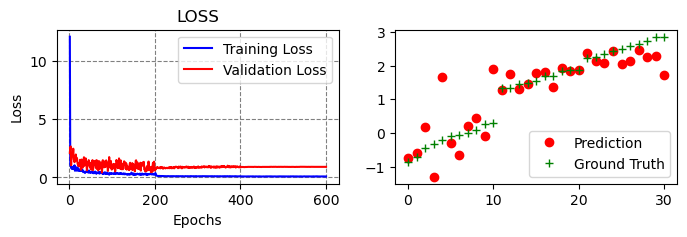

Pearson CC: 0.8654125841606438
R2 score: 0.745284954461165
RMSE: 0.5923551917076111
MAE: 1.2677724361419678
********************
Run # 1 Fold # 2


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:01:21.373326


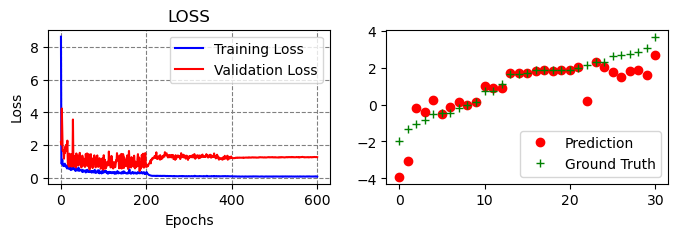

Pearson CC: 0.87182133773986
R2 score: 0.6989459264294582
RMSE: 0.7919855117797852
MAE: 1.5792717933654785
********************
Run # 1 Fold # 3


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:01:18.256764


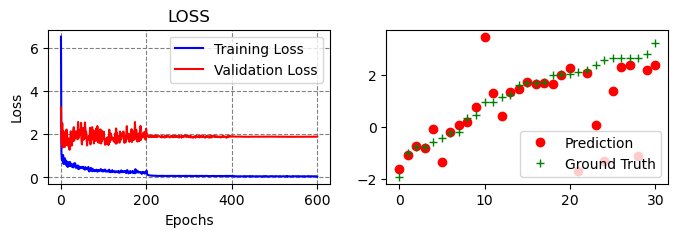

Pearson CC: 0.5520325160503137
R2 score: -0.07324640035866148
RMSE: 1.4000287055969238
MAE: 1.6315226554870605
********************
Run # 1 Fold # 4


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:01:18.060161


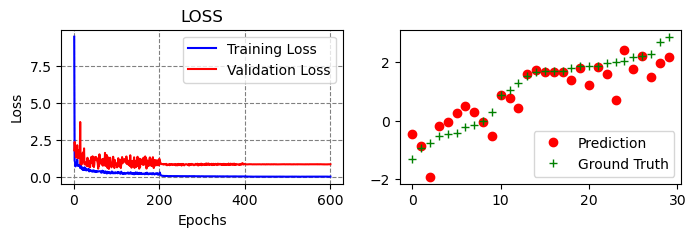

Pearson CC: 0.8903019795745355
R2 score: 0.7761488634616253
RMSE: 0.5604574680328369
MAE: 1.2583342790603638
********************
Run # 1 Fold # 5


c:\Users\L\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Training time: 0:01:20.063355


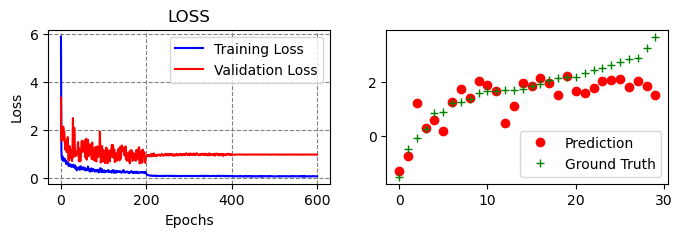

Pearson CC: 0.8032272039134727
R2 score: 0.5594227480874112
RMSE: 0.7233482599258423
MAE: 1.0651947259902954
********************


In [14]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # define DNN
            model = Sequential()
            model.add(Input(shape=(24,)))
            model.add(Dense(1000,activation='relu'))
            model.add(Dense(200,activation='relu'))
            model.add(Dense(40,activation='relu'))
            model.add(Dense(1,activation='linear'))

            model.compile(optimizer= 'RMSprop', loss=root_mean_squared_error)

            # learning rate scheduler
            import math
            INITIAL_LEARNING_RATE = 0.01
            EPOCHS_NUM = 600
            def lr_step_decay(epoch, lr):
                drop_rate = 0.1
                epochs_drop = 200
                return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

            callbacks=[LearningRateScheduler(lr_step_decay, verbose=0)]

            # Fit model
            t = now()
            history = model.fit(x_train, y_train, batch_size=16, epochs=EPOCHS_NUM,
                                validation_split=0.2, verbose=0, callbacks=callbacks)
            print('Training time: %s' % (now() - t))

            # Plot the loss and the predictions
            train_loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochsn = np.arange(1, len(train_loss)+1,1)
            plt.figure(figsize=(8, 2))
            plt.subplot(1,2,1)
            plt.plot(epochsn,train_loss, 'b', label='Training Loss')
            plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
            plt.grid(color='gray', linestyle='--')
            plt.legend()
            plt.title('LOSS')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.subplot(1,2,2)
            y_pred_test = model.predict(x_test, verbose=0)
            plt.plot(y_pred_test, 'ro', label='Prediction')
            plt.plot(np.array(y_test), 'g+', label='Ground Truth')
            plt.legend(loc=4)
            plt.show()

            # Evaluate metrics
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred_test))[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

In [15]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.865413,0.745285,0.592355,1.267772
1,0.871821,0.698946,0.791986,1.579272
2,0.552033,-0.073246,1.400029,1.631523
3,0.890302,0.776149,0.560457,1.258334
4,0.803227,0.559423,0.723348,1.065195


In [16]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.796559,0.125722,0.541311,0.316105,0.813635,0.305137,1.360419,0.213333
